In [ ]:
import requests
import json
import pandas as pd
import re
import time
import os
import random
import matplotlib.pyplot as plt
from bs4 import BeautifulSoup
from requests.adapters import HTTPAdapter
from urllib3.util.retry import Retry
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
import csv

# Set up necessary directories and configurations
os.makedirs('data', exist_ok=True)
session = requests.Session()
retries = Retry(total=3, backoff_factor=1, status_forcelist=[500, 502, 503, 504])
session.mount('http://', HTTPAdapter(max_retries=retries))
session.mount('https://', HTTPAdapter(max_retries=retries))
nltk.download('punkt')

# Function to clean title by standardizing the "By H. P. Lovecraft" text
def clean_title(title):
    author_text = "By H. P. Lovecraft"
    # Remove duplicate "By H. P. Lovecraft" and standardize spacing
    title = re.sub(rf"({author_text}\s*)+", author_text, title).strip()
    if title.endswith(author_text) and not title.endswith(" " + author_text):
        title = title.replace(author_text, " " + author_text)
    return title

# --- Step 1: Scraping Lovecraft Works ---
def scrape_lovecraft_content(content_type):
    base_url = "https://www.hplovecraft.com/writings/texts/"
    response = session.get(base_url)
    
    if response.status_code != 200:
        print(f"Failed to access the base URL: {response.status_code}")
        return
    
    soup = BeautifulSoup(response.content, 'html.parser')
    content_links = [
        f"{base_url}{link['href']}"
        for link in soup.find_all('a', href=True)
        if link['href'].startswith(f'{content_type}/') and not link['href'].startswith('#')
    ]

    # CSV for saving the scraped data
    csv_filename = f'data/lovecraft_{content_type}.csv'
    with open(csv_filename, 'w', newline='', encoding='utf-8') as csvfile:
        csvwriter = csv.writer(csvfile)
        csvwriter.writerow(['Content Type', 'Title', 'Text'])

        for content_url in content_links:
            time.sleep(random.uniform(1, 3))
            try:
                content_response = session.get(content_url, headers={'User-Agent': 'Mozilla/5.0'})
                if content_response.status_code == 200:
                    content_soup = BeautifulSoup(content_response.content, 'html.parser')
                    title_tag = content_soup.find('font', size="+2")
                    author_tag = content_soup.find('font', size="+1")
                    text_div = content_soup.find('div', align='justify')

                    if title_tag and text_div:
                        title = f"{title_tag.get_text(strip=True)} by {author_tag.get_text(strip=True)}"
                        title = clean_title(title)  # Clean the title text
                        csvwriter.writerow([content_type, title, text_div.get_text(strip=True)])
                        print(f'Scraped: {title}')
                    else:
                        print(f'Title or text not found for {content_url}')
                else:
                    print(f'Failed to scrape {content_url}: {content_response.status_code}')
            except Exception as e:
                print(f'Error scraping {content_url}: {e}')

# Scrape for all specified content types
for content in ['fiction', 'poetry', 'essays', 'letters']:
    scrape_lovecraft_content(content)

# --- Step 2: API Data Collection ---
def fetch_and_save_json(api_url, filename):
    response = session.get(api_url)
    if response.status_code == 200:
        with open(f'data/{filename}.json', 'w', encoding='utf-8') as file:
            json.dump(response.json(), file, ensure_ascii=False, indent=4)
        print(f"{filename.capitalize()} data saved successfully!")
    else:
        print(f"Failed to retrieve {filename} data: {response.status_code}")

# Fetch and save various categories
api_categories = {
    "creatures": "https://lovecraftapirest.fly.dev/api/creatures",
    "races": "https://lovecraftapirest.fly.dev/api/races",
    "outer_gods": "https://lovecraftapirest.fly.dev/api/categories/outer-gods",
    "great_old_ones": "https://lovecraftapirest.fly.dev/api/categories/great-old-ones",
    "lesser_old_ones": "https://lovecraftapirest.fly.dev/api/categories/lesser-old-ones"
}

for name, url in api_categories.items():
    fetch_and_save_json(url, name)


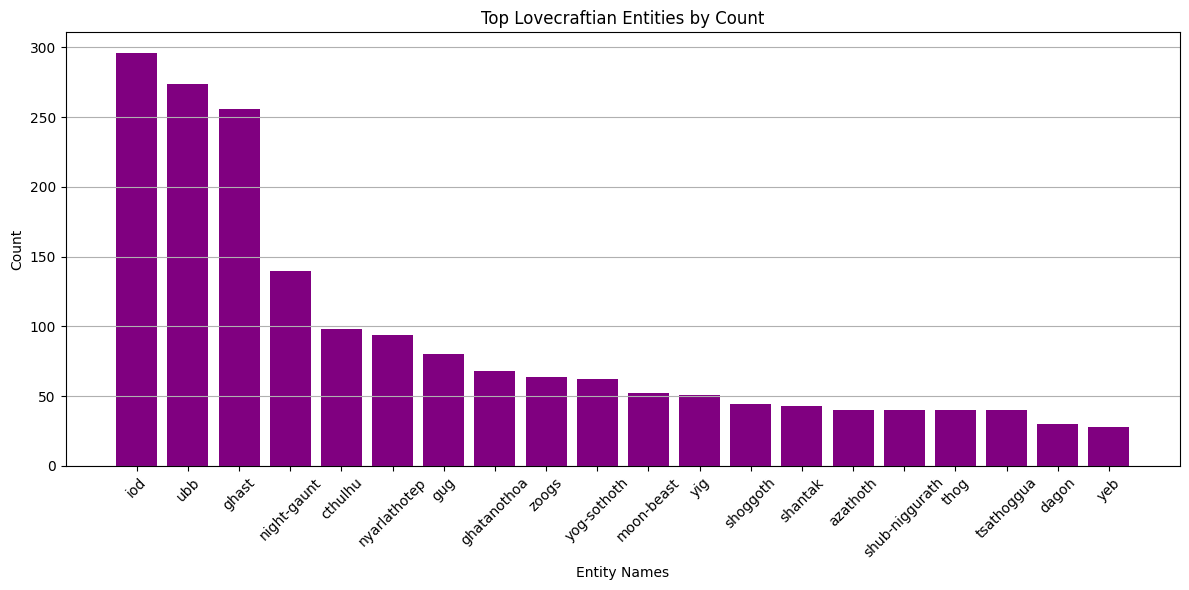

In [9]:
import json
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# --- Step 3: Load and Clean Data ---
# Load JSON files
with open('data/creatures.json') as f:
    creatures = json.load(f)

with open('data/great_old_ones.json') as f:
    great_old_ones = json.load(f)

with open('data/lesser_old_ones.json') as f:
    lesser_old_ones = json.load(f)

with open('data/outer_gods.json') as f:
    outer_gods = json.load(f)

with open('data/races.json') as f:
    races = json.load(f)

# Load CSV file with Lovecraft fiction
lovecraft_data = pd.read_csv('data/lovecraft_fiction.csv')

# Combine all entity names and add a 'Type' for each entity
all_entities = []

# Add creatures with type 'Creature'
all_entities.extend([{'name': creature['name'], 'type': 'Creature'} for creature in creatures])

# Add Great Old Ones with type 'Great Old One'
all_entities.extend([{'name': old_one['name'], 'type': 'Great Old One'} for old_one in great_old_ones])

# Add Lesser Old Ones with type 'Lesser Old One'
all_entities.extend([{'name': old_one['name'], 'type': 'Lesser Old One'} for old_one in lesser_old_ones])

# Add Outer Gods with type 'Outer God'
all_entities.extend([{'name': old_one['name'], 'type': 'Outer God'} for old_one in outer_gods])

# Add races with type 'Race'
all_entities.extend([{'name': race['race'], 'type': 'Race'} for race in races])

# Clean names to lowercase for case-insensitive matching and merge ghoul entities
all_names = [entity['name'].lower() for entity in all_entities]
all_types = [entity['type'] for entity in all_entities]

# Merge plural forms and combine duplicates
def clean_name(name):
    name_corrections = {
        'ghoul': 'ghoul',
        'dark young': 'dark young of shub-niggurath',
        'deep one': 'deep one',
        'dimensional shambler': 'dimensional shambler',
        'elder thing': 'elder thing',
        'flying polyp': 'flying polyp',
        'ghast': 'ghast',
        'gug': 'gug',
        'hound of tindalos': 'hound of tindalos',
        'moon-beast': 'moon-beast',
        'night-gaunt': 'night-gaunt',
        'shoggoth': 'shoggoth',
        'spider of leng': 'spider of leng',
        'star spawn of cthulhu': 'star spawn of cthulhu',
        'tcho-tcho': 'tcho-tcho'
    }
    # Clean the name to ensure it matches the corrected form
    for singular, corrected in name_corrections.items():
        if singular in name:
            return corrected
    return name

# Apply the cleaning function to the list of names
all_names = [clean_name(name) for name in all_names]

# Drop unwanted terms: 'han', 'ghoul', and 'darkness'
unwanted_terms = ['han', 'ghoul', 'darkness']
all_names = [name for name in all_names if name not in unwanted_terms]

# --- Step 4: Filter Texts by Names and Count Occurrences ---
def filter_texts(data_frame, names):
    return [text for text in data_frame['Text'] if any(name in text.lower() for name in names)]

filtered_texts = filter_texts(lovecraft_data, all_names)

# Count occurrences with merged ghoul entities and cleaned names
name_counts = Counter()
for text in filtered_texts:
    for name in all_names:
        name_counts[name] += text.lower().count(name)

# Create a DataFrame for name counts
name_counts_df = pd.DataFrame(name_counts.items(), columns=['Name', 'Count'])

# Add the 'Type' column based on name matching
name_counts_df['Type'] = name_counts_df['Name'].apply(
    lambda name: all_types[all_names.index(name)] if name in all_names else 'Unknown'
)

# Save the name counts with types
name_counts_df.to_csv('data/lovecraft_name_counts.csv', index=False)

# --- Step 5: Visualization ---
def plot_top_entities(counts_df, top_n=10, exclude=None):
    exclude = exclude or []
    filtered_df = counts_df[~counts_df['Name'].isin(exclude)]
    top_entities = filtered_df.nlargest(top_n, 'Count')

    plt.figure(figsize=(12, 6))
    plt.bar(top_entities['Name'], top_entities['Count'], color='purple')
    plt.title('Top Lovecraftian Entities by Count')
    plt.xlabel('Entity Names')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Load updated name counts if needed and plot
plot_top_entities(name_counts_df, top_n=20, exclude=['darkness'])


In [10]:
import pandas as pd

# Load the CSV
name_counts_df = pd.read_csv('data/lovecraft_name_counts.csv')

# Show the top 10 most common entities
top_entities = name_counts_df.sort_values(by='Count', ascending=False).head(10)
print(top_entities)

# Show the least common entities
least_common_entities = name_counts_df.sort_values(by='Count', ascending=True).head(10)
print(least_common_entities)

# You can also filter by entity type (if it's included in your dataset)
# For example, if you have a 'Type' column:
# lovecraft_data_filtered = name_counts_df[name_counts_df['Type'] == 'Great Old One']


             Name  Count      Type
46            iod    296  Creature
99            ubb    274  Creature
29          ghast    256  Creature
61    night-gaunt    140  Creature
15        cthulhu     98  Creature
65   nyarlathotep     94  Creature
39            gug     80  Creature
30    ghatanothoa     68  Creature
115         zoogs     64  Creature
112   yog-sothoth     62  Creature
               Name  Count      Type
0    'umr at-tawill      0  Creature
1            abhoth      0  Creature
2      apocolothoth      0  Creature
3     atlach-natcha      0  Creature
5           basatan      0  Creature
7           byakhee      0  Creature
9   cat from saturn      0  Creature
8            byatis      0  Creature
14          cthugha      0  Creature
12        chthonian      0  Creature
